### Load library and package

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.feature_extraction.text import CountVectorizer

### Read the csv file as dataframe

In [27]:
df = pd.read_csv("/home/workspace/src/Train.zip")
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


### Eliminate rows which are duplicated or have missing values 

In [28]:
df = df.drop_duplicates(['Title', 'Body', 'Tags'])
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4206307 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 160.5+ MB


### Analyze Tag occurence distribution (unit : Question)

<Axes: xlabel='tag_count'>

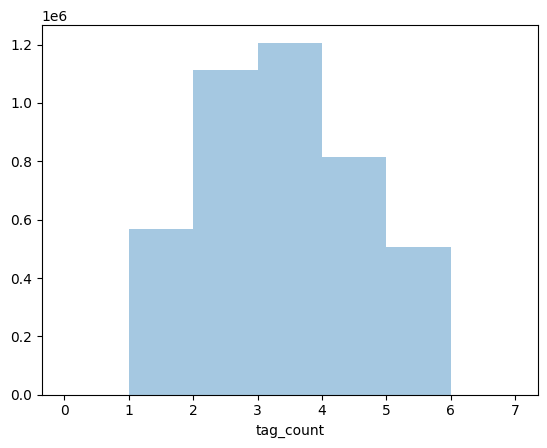

In [30]:
df["tag_count"] = df["Tags"].apply(lambda row : len(str(row).split(" ")))
#df.tag_count.value_counts()

sns.distplot(df['tag_count'],
             bins=list(range(0, 8)), 
             kde=False, hist=True)

### Analyze Tag occurence distribution (unit : Tag)

In [5]:
vectorizer = CountVectorizer(tokenizer= lambda text : text.split(" "))
tag_dtm = vectorizer.fit_transform(df["Tags"])
tags = vectorizer.get_feature_names_out()
freqs = tag_dtm.sum(axis=0).A1

tag_df = pd.DataFrame(dict(zip(tags, freqs)).items(), columns=["Tags", "Counts"])
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted["Counts"].values
print(f"the number of tags is {len(tags)}\n")

the number of tags is 42048



>> ##### Top 100 Tags

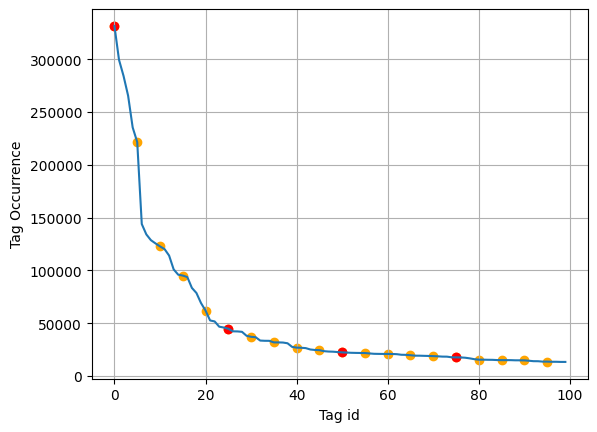

In [6]:
plt.plot(tag_counts[:100])
plt.scatter(x= list(range(0,100,5)), y = tag_counts[0:100:5], c= 'orange', label = "Quantiles with 5 % intervals")
plt.scatter(x= list(range(0,100,25)), y = tag_counts[0:100:25], c = "red", label = "Quantiles with 25th % intervals")
plt.grid()
plt.xlabel("Tag id")
plt.ylabel("Tag Occurrence")
plt.show()

>> ##### Top 10000 Tags

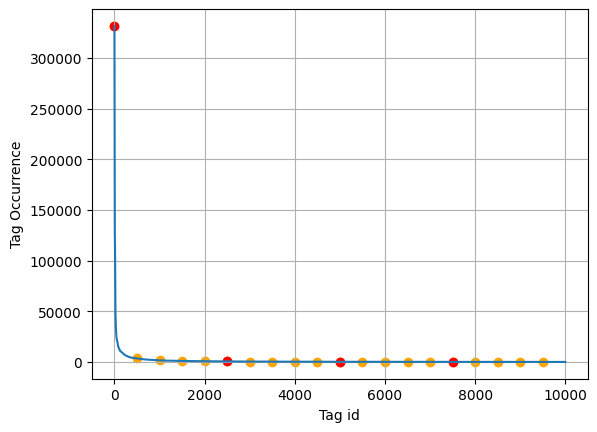

In [7]:
plt.plot(tag_counts[:10000])
plt.scatter(x= list(range(0,10000,500)), y = tag_counts[0:10000:500], c= 'orange', label = "Quantiles with 5 % intervals")
plt.scatter(x= list(range(0,10000,2500)), y = tag_counts[0:10000:2500], c = "red", label = "Quantiles with 25th % intervals")
plt.grid()
plt.xlabel("Tag id")
plt.ylabel("Tag Occurrence")
plt.show()

### Preprocess data

In [8]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',str(data))
    return cleantext

In [9]:
preprocessed_data_list = []
for row in df.iterrows():
    title, body, tags = row[1][1], row[1][2], row[1][3]

    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body=striphtml(body.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(body)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    question = question.replace("\n", "").replace("\t", "")
    question=' '.join(str(t) for t in question.split() if len(t)!=1 or t=='c')

    preprocessed_data_list.append([question, tags])

preprocessed_df = pd.DataFrame(preprocessed_data_list, columns=['question','tags'])
preprocessed_df.head()
df = None
#processed_df.to_csv("preprocessed_train.csv")

##### Analyze the length of Question using BertTokenizer

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
preprocessed_df['question_len'] = preprocessed_df['question'].apply(
    lambda x: len(tokenizer.tokenize(x))
    )

>> ##### Length of Questions

<Axes: xlabel='question_len'>

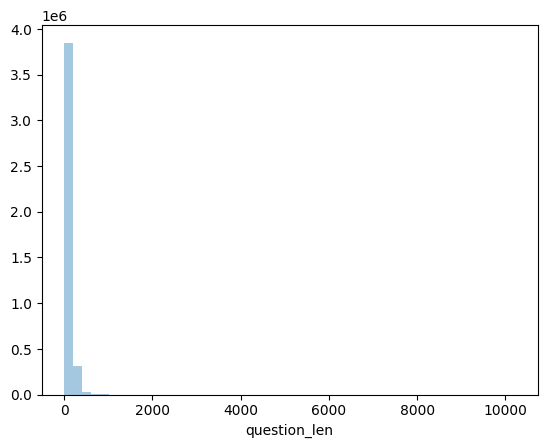

In [32]:
sns.distplot(preprocessed_df['question_len'], 
             hist=True, kde=False)

>> ##### Length of Questions (Max subwords = 1000)

<Axes: xlabel='question_len'>

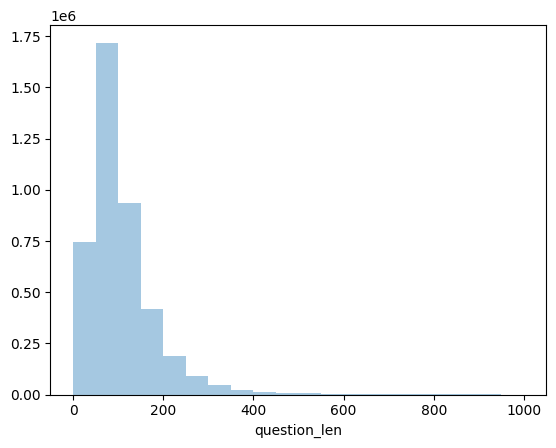

In [25]:
sns.distplot(preprocessed_df['question_len'],
             bins=list(range(0, 1050, 50)),
             hist=True, kde=False)

### Analyze relation between Tag and Question 

In [11]:
# Make question-tag matrix

vectorizer = CountVectorizer(tokenizer= lambda text : text.split(), binary=True)
multilabel_y = vectorizer.fit_transform(preprocessed_df["tags"])
multilabel_y.shape

(4206307, 42048)

In [12]:
def tags_to_choose(n, multilabel_y):
    tag_freqs = multilabel_y.sum(axis=0).tolist()[0]
    tag_idxs = list(range(multilabel_y.shape[1]))
    sorted_tag_idxs = sorted(tag_idxs, key=lambda idx: tag_freqs[idx], reverse=True)
    
    n_multilabel_y = multilabel_y[:, sorted_tag_idxs[:n]]
    # n_multilabel_y = (questions, top_n_tags)

    return n_multilabel_y

def questions_explained_fn(n, multilabel_y):
    n_multilabel_y = tags_to_choose(n, multilabel_y)
    tag_freqs_per_qs = n_multilabel_y.sum(axis=1)
    # tag_freqs_per_qs = (questions, 1)
    
    return (np.count_nonzero(tag_freqs_per_qs == 0))

In [13]:
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_df.shape[0]

max_n_list = list(range(1000, 11000, 1000))
questions_explained = []
for n in max_n_list:
    questions_not_explained = (total_qs-questions_explained_fn(n, multilabel_y)) / total_qs
    questions_explained.append(np.round(questions_not_explained*100, 2))

questions_explained

[94.16, 96.95, 98.02, 98.56, 98.9, 99.13, 99.28, 99.41, 99.51, 99.59]

>> ##### Questions covered by top n Tags partially (%)

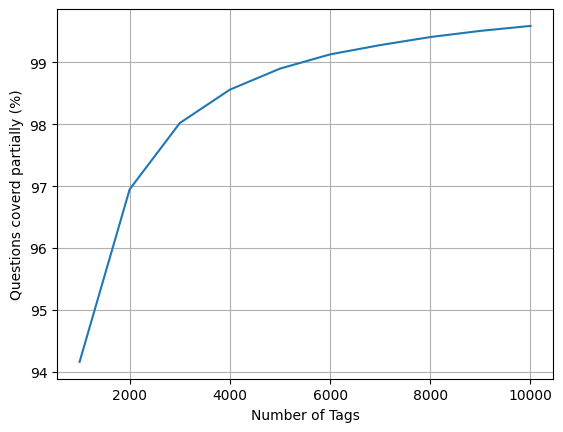

In [14]:
data_dict = {'x':max_n_list, 'y':questions_explained}
plt.plot('x', 'y', data=data_dict)
plt.xlabel("Number of top n Tags")
plt.ylabel("Questions coverd partially (%)")
plt.grid()
plt.show()

##### Select Top 6000 Tags as the multi-label of Question

In [15]:
n_multilabel_y = tags_to_choose(6000, multilabel_y)
print(f"6000 Tags are covering {questions_explained[5]}% Questions")

6000 Tags are covering 99.13% Questions
